# Crop Classification from Sentinel-2 Satellite Imagery with XGBoosted Trees

## Outline

1) [Collect and clean data](#Data)
2) [Feature selection](#Feature-selection)
3) [Build and tune model](#Build-model)
4) [Evaluate model](#Evaluate-model)
5) [Next steps](#Next-steps)

## Data

This tutorial is based on previous work to predict high-resolution seasonal maize class and yield in Rwanda. It is recommended to review the enclosed paper for greater detail on context, data sources and types, and the aims/challenges of this work. However, briefly:

Optical imagery from the Sentinel-2 satellite and auxiliary data on climate, geography, and geopolitical boundaries were used in supervised learning with crop cut data (primarily) collected in the field.  

Land cover was classified into nine mutually exclusive groups: 1) maize, 2) non-maize annual crops (e.g. beans, potatoes, cassava), 3) non-maize perennial crops (e.g. bananas), 4) forest and tree cover, 5) shrub and scrubland, given the shorthand name of rangeland here, 6) structure and built environment, 7) bare ground, 8) wetland, 9) water bodies. 

The raw spectral output of 12 Sentinel-2 bands as well as several derived indices were summarized by agricultural season with distributional statistics (mean, standard deviation, min, max).

One Acre Fund (OAF) provided the crop cut data for major crops in Rwanda while data for other land cover classes was augmented with RTI International annotated drone imagery and existing global land cover products from Dynamic World (DW), Impact Observatory (IO), and the European Space Agency (ESA).

See the following table for detail on each input feature. The data provided to you includes all of these variables, but for the purposes of this tutorial we will only use a subset.  

![Table 1: Predictor Descriptions](./data/predictor_descriptions.png)

## Environment Setup

In [15]:
# some general packages we'll use:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format  # limit decimal places displayed for easier viewing

In [17]:
data_raw = pd.read_parquet('./data/training_data_for_classifier.parquet')

In [18]:
# sample size by land cover class
data_raw['crop_type'].value_counts(dropna=False)

crop_type
nonmaize_annual       19957
maize                  9719
forest                 8645
rangeland              3187
water                  2994
wetland                2887
structure              2345
nonmaize_perennial      363
bare                    345
Name: count, dtype: int64

In [19]:
# sample size by data source
data_raw['crop_id'].apply(lambda s: re.sub(r"_[0-9]+", "", s)).value_counts(dropna=False)

crop_id
oaf          28881
dw_io_esa    19757
rti           1804
Name: count, dtype: int64

## Feature selection

In the paper, we used an empirical feature selection strategy that chose variables with the highest Mutual Information Scores that were not highly correlated with other variables. 

Here, we will manually select variables given our expert knowledge and build a model from mean seasonal Sentinel-2 spectral information, one derived index, and topographic information from a Digital Elevation Model (DEM).

What other features do you think might be predictive of land cover type?  

In [20]:
id_cols = ['crop_id', 'crop_type', 'label', 'intercrop', 'season', 'sos_actual']
s2_predictors = data_raw.columns[data_raw.columns.str.contains("B[0-9]*_mean$")].tolist()
topo_predictors = ['elevation', 'slope', 'aspect']
predictors = s2_predictors + topo_predictors

In [21]:
data = data_raw.filter(id_cols + predictors)

In [22]:
# Take a look at the data subset:
data

,crop_id,crop_type,label,intercrop,season,sos_actual,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,B8_mean,B9_mean,B11_mean,B12_mean,elevation,slope,aspect
0,oaf_53465,maize,mze,0.00,2023_Season_A,20220901,0.04,0.04,0.07,0.07,0.12,0.27,0.30,0.30,0.32,0.18,0.11,1770.83,8.63,204.91
1,oaf_47129,nonmaize_annual,pot,1.00,2023_Season_A,20220901,0.05,0.05,0.07,0.07,0.11,0.21,0.24,0.23,0.27,0.18,0.13,2259.86,4.84,99.71
2,oaf_52319,nonmaize_annual,bub,1.00,2023_Season_A,20220901,0.04,0.05,0.07,0.07,0.13,0.26,0.30,0.31,0.29,0.25,0.17,1622.87,8.22,299.02
3,oaf_58952,maize,mze,1.00,2023_Season_A,20220901,0.04,0.05,0.07,0.08,0.12,0.20,0.22,0.22,0.25,0.21,0.15,1742.83,11.63,118.19
4,oaf_56441,nonmaize_annual,clb,1.00,2023_Season_A,20220901,0.05,0.06,0.10,0.11,0.17,0.25,0.27,0.28,0.28,0.25,0.18,2212.32,13.50,260.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50437,oaf_622,nonmaize_annual,pot,0.00,2022_Season_A,20210901,0.04,0.05,0.09,0.08,0.14,0.28,0.32,0.30,0.35,0.24,0.15,1911.79,5.74,180.00
50438,oaf_11209,nonmaize_annual,bub,1.00,2022_Season_A,20210901,0.05,0.05,0.07,0.08,0.12,0.22,0.25,0.25,0.26,0.21,0.15,1420.75,3.20,308.59
50439,oaf_9394,nonmaize_annual,pot,0.00,2022_Season_A,20210901,0.06,0.07,0.10,0.09,0.16,0.34,0.40,0.40,0.40,0.27,0.16,2120.43,15.62,338.31
50440,oaf_5217,nonmaize_annual,bub,0.00,2022_Season_A,20210901,0.05,0.06,0.09,0.10,0.13,0.21,0.23,0.22,0.24,0.21,0.15,1424.67,8.88,312.61


Let's compute the Normalized Difference Vegetation Index (NDVI), one of the most commonly used indices to measure vegetative health from satellite data. 

NDVI is a ratio between the Red and Near-Infrared bands and measures the amount of red light and near-infrared light absorbed on the ground. Typically, a plant is healthier if it absorbs more red light relative to infrared light (NDVI close to 1) while NDVI values close to 0 or negative values can indicate unhealthy vegetation or areas of non-vegetation such as bare ground, structures, or fallowed fields.

(Note: The mean seasonal NDVI we calculate will be different than that given in the raw data ('ndvi_mean') because the latter represents a mean of daily NDVIs whereas here we are computing mean NDVI from variables that are already averaged over the season.)

In [23]:
def compute_ndvi(b8, b4): 
    return (b8-b4) / (b8+b4)

data['ndvi_mean'] = data.apply(lambda df: compute_ndvi(df['B8_mean'], df['B4_mean']), axis=1)

# add to predictors list
predictors = predictors + ['ndvi_mean']

## Build model

We will use a gradient boosted decision tree to predict land cover type. Particularly, the model we will use is called XGBoost (Extreme Gradient Boosting).

The advantages of this model for our prediction task are:
* Supervised learning that can solve both regression and classification, including multinomial, problems
* Non-parametric so does not require a lot of assumptions
* More easily solves non-linear problems with decision boundaries
* Hierarchical and detects interactions between features
* Accepts heterogeneous data, robust to outliers, and requires less pre-processing (e.g. does not require feature scaling or normalization)

What are some of the limitations?

### Additional steps before modeling 
The model expects that the target (i.e. outcome) is numeric and that the dataset does not contain missing data so first we must do some additional cleaning. 

In order to tune and evaluate our model on independent datasets we need to split our data into training and testing sets. 

In [24]:
# additional packages needed for modeling
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [25]:
# create nominal outcome 
data['land_cover_class'] = pd.Categorical(  # order that matches original paper
    data['crop_type'],
    categories=['maize', 'nonmaize_annual', 'nonmaize_perennial', 'rangeland', 'forest', 'wetland', 'water', 'structure', 'bare'],  
    ordered=True
    )
data['land_cover_class_encoded'] = data['land_cover_class'].cat.codes

# remove missing data in outcome and predictors (if any)
data.dropna(subset = ['land_cover_class_encoded'] + predictors, inplace = True)


In [26]:
# split dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    data.filter(predictors), # predictors
    data['land_cover_class_encoded'], # outcome
    test_size=0.2, # 20% of data reserved for testing set
    random_state=123  # seed for reproducibility 
)
print("Size of training dataset: {} observations".format(len(x_train)))
print("Size of test dataset: {} observations".format(len(x_test)))

# set up model
dtrain = xgb.DMatrix(x_train, label=y_train)  # xgb expects data to be a DMatrix object 
dtest = xgb.DMatrix(x_test, label=y_test)

Size of training dataset: 40353 observations
Size of test dataset: 10089 observations


Later we will tune our model to select the best hyperparameters, but for now use the following given hyperparameters. A full list of those available in XGBoost can be found [here](https://xgboost.readthedocs.io/en/latest/parameter.html). 

In [27]:
# choose hyperparameters
param = {
    'objective': 'multi:softmax',  # ours is a multinomial classification problem; this will output the multiclass classification using the softmax objective
    'num_class': data['land_cover_class_encoded'].nunique(),  # specify number of classes in outcome
    'eval_metric': ['mlogloss', 'merror'],  # 'mlogloss' = multinomial negative log-likelihood, 'merror' = multiclass classification error rate
    'subsample': 0.5,  # helps to prevent overfitting
    'sampling_method': 'uniform',
    'eta': 0.3,  # learning rate, helps to prevent overfitting
    'max_depth': 6,  # maximum depth of tree, controls complexity
    'min_child_weight': 1,  # min samples in each node, controls complexity
    'seed': 529  # for reproducibility
}

In [28]:
# train model
classifier = xgb.train(params=param, dtrain=dtrain, 
                       num_boost_round=1000,  # number of boosting iterations, 
                       early_stopping_rounds=100,  # helps control overfitting
                       evals=[(dtrain, 'train'), (dtest, 'eval')], verbose_eval=100
                       )

[0]	train-mlogloss:1.60604	train-merror:0.32875	eval-mlogloss:1.61553	eval-merror:0.33809
[100]	train-mlogloss:0.35153	train-merror:0.12353	eval-mlogloss:0.66662	eval-merror:0.26851
[200]	train-mlogloss:0.21221	train-merror:0.04882	eval-mlogloss:0.69758	eval-merror:0.27208
[217]	train-mlogloss:0.19592	train-merror:0.04176	eval-mlogloss:0.70208	eval-merror:0.27099


In [29]:
# output performance on testing set, considering early stopping 
print("Best Error: {:.2f} with {} rounds".format(
                 classifier.best_score,
                 classifier.best_iteration+1))

Best Error: 0.27 with 119 rounds


## Tune model

The architecture of the gradient boosted tree, defined by hyperparameters, is often specific to the data and target. Choosing the right parameter values can have a big impact on performance. Hyperparameter tuning is the process by which you run a model with different sets of parameter values and choose the best settings empirically. 

We will look at two parameters that control model complexity and overfitting: maximum tree depth and learning rate. 
* `max_depth`: Deeper trees increase complexity and contain more information about the interactions between predictors, but may increase noise.
* `eta`: The shrinkage parameter is a regularization parameter applied to each tree to control for overfitting; with a sufficient number of boosting iterations, smaller values are likely to give more accurate results.

The number of boosting iterations, or trees, (`num_boost_round`) is also an important hyperparameter and inversely proportional to the learning rate: as the learning rate decreases, the number of trees must increase  for the model to converge as the model is learning less information at each step. Here, we capture the optimal number of iterations with early stopping, which stops training if performance has not improved for a specified number of rounds (here, n=100). 

We will evaluate the relative performance of each setting with 5-fold cross-validation using the training set alone. 

In [30]:
gridsearch_params = [
    (max_depth, eta)
    for max_depth in [4, 6, 8]
    for eta in [0.2, 0.1, 0.01]
]

⚠️ Note: This next code block will take some time to run. On an Apple M1 Pro (3.2 GHz 8-core) processor with 16 GB RAM, it took 15-20 minutes to complete. On an Apple M4 Pro processor with 24GB RAM (14-core), it still took 15 minutes. 

In [31]:
# Run hyperparameter search 
min_mlogloss = float("Inf")
best_params = None

for max_depth, eta in gridsearch_params:
    print("CV with max_depth={}, eta={}".format(max_depth, eta))
    
    # Update parameters
    param['max_depth'] = max_depth
    param['eta'] = eta
    
    # Run CV
    cv_results = xgb.cv(
        params=param, 
        dtrain=dtrain,
        num_boost_round=3000,
        early_stopping_rounds=100,
        nfold=5
    )
    
    # Update best performance
    mean_mlogloss = cv_results['test-mlogloss-mean'].min()
    n_boost = cv_results['test-mlogloss-mean'].argmin()
    print("\tmlogloss {} for {} rounds".format(mean_mlogloss, n_boost))
    if mean_mlogloss < min_mlogloss:
        min_mlogloss = mean_mlogloss
        best_params = {'max_depth': max_depth, 'eta': eta, 'num_boost_round': int(n_boost+1)}

CV with max_depth=4, eta=0.2
	mlogloss 0.6504654950486717 for 232 rounds
CV with max_depth=4, eta=0.1
	mlogloss 0.6435659518351516 for 548 rounds
CV with max_depth=4, eta=0.01
	mlogloss 0.64852967047275 for 2999 rounds
CV with max_depth=6, eta=0.2
	mlogloss 0.6562539046872639 for 112 rounds
CV with max_depth=6, eta=0.1
	mlogloss 0.6475089966915444 for 237 rounds
CV with max_depth=6, eta=0.01
	mlogloss 0.6388234224476901 for 2410 rounds
CV with max_depth=8, eta=0.2
	mlogloss 0.6683007245851111 for 58 rounds
CV with max_depth=8, eta=0.1
	mlogloss 0.6546543244280888 for 146 rounds
CV with max_depth=8, eta=0.01
	mlogloss 0.6436071827619152 for 1537 rounds


When max depth was equal to 4 and learning rate was equal to 0.01 it looks like the error never reached a saturation point up to 3000 boosting iterations, so we may consider increasing the numbering of rounds, but we should also keep in mind that any marginal gain in performance may not be worth the computation time required. 


In [32]:
print("Best params:", best_params)

Best params: {'max_depth': 6, 'eta': 0.01, 'num_boost_round': 2411}


Let's train a model with these settings on the full training set (i.e. no cross-validation) and then evaluate performance on the test set. This takes about 1 minute to run.

In [33]:
# update param dictionary with best settings
param.update({k:v for k,v in best_params.items() if k in param.keys()})

# final model
best_classifier = xgb.train(params=param, dtrain=dtrain, 
                            num_boost_round=best_params['num_boost_round'])


## Evaluate model

In [34]:
from sklearn.metrics import (balanced_accuracy_score, accuracy_score,
                             f1_score, precision_recall_fscore_support,
                             matthews_corrcoef, confusion_matrix)

# get class predictions on test set
y_pred = best_classifier.predict(dtest)

In [35]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
land_cover_classes = data['land_cover_class'].cat.categories.tolist()

cm_pd = pd.DataFrame(cm, index=land_cover_classes, columns=land_cover_classes).rename_axis("actual/pred")
cm_pd

,maize,nonmaize_annual,nonmaize_perennial,rangeland,forest,wetland,water,structure,bare
actual/pred,,,,,,,,,
maize,676,1182,0,20,47,1,0,30,0
nonmaize_annual,365,3435,1,42,114,0,0,40,0
nonmaize_perennial,15,18,41,0,1,0,0,3,0
rangeland,15,211,0,371,29,1,0,2,0
forest,28,129,0,25,1461,18,0,0,0
wetland,0,2,0,2,22,536,1,0,0
water,0,0,0,0,2,8,606,0,0
structure,34,201,0,2,0,0,0,275,3
bare,0,0,0,0,0,0,0,2,72


What is maize cover most commonly mistaken as? Which categories is it most easily differentiated from?

In [36]:
# overall performance considering all land cover types
overall_eval = pd.DataFrame(data=np.array([    
    balanced_accuracy_score(y_test, y_pred),
    f1_score(y_test, y_pred, average='weighted'),
    matthews_corrcoef(y_test, y_pred)]),
    columns = ["overall"], index= ['balanced_accuracy', 'weighted_f1_score', 'mcc'])
overall_eval

,overall
balanced_accuracy,0.74
weighted_f1_score,0.73
mcc,0.66


In [37]:
# performance by land cover class
eval_by_class = pd.DataFrame(data = np.concatenate([
    np.expand_dims(np.array([accuracy_score(np.array(y_test) == i, np.array(y_pred) == i) for i, name in enumerate(land_cover_classes)]), 0),
    np.vstack(precision_recall_fscore_support(y_test, y_pred, average=None))], axis=0),
             columns = land_cover_classes,
             index = ['accuracy', 'precision', 'recall', 'f1_score', 'n'])
eval_by_class

,maize,nonmaize_annual,nonmaize_perennial,rangeland,forest,wetland,water,structure,bare
accuracy,0.83,0.77,1.00,0.97,0.96,0.99,1.00,0.97,1.00
precision,0.60,0.66,0.98,0.80,0.87,0.95,1.00,0.78,0.96
recall,0.35,0.86,0.53,0.59,0.88,0.95,0.98,0.53,0.97
f1_score,0.44,0.75,0.68,0.68,0.88,0.95,0.99,0.63,0.97
n,1956.00,3997.00,78.00,629.00,1661.00,563.00,616.00,515.00,74.00


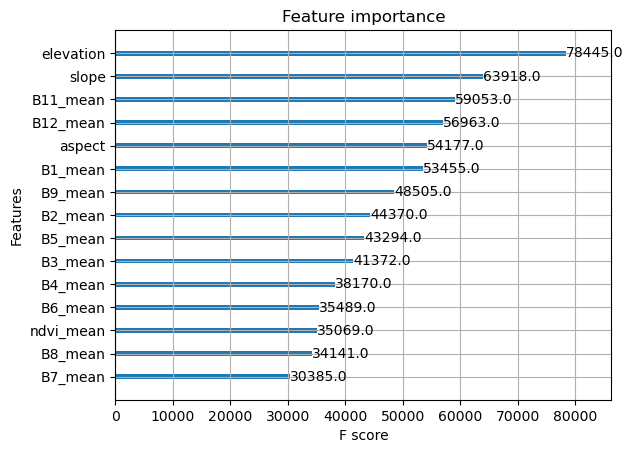

In [38]:
# variable importance plot
xgb.plot_importance(best_classifier)
plt.show()

Which predictors were most informative? Which spectral information was most informative? Can you imagine why these features would be most predictive of land cover class? Keep in mind this is for all land cover classes, not just crops/vegetation. 

## Assignment

How could you improve the prediction of land cover class, and specifically maize? Would you choose different variables? continue to fine tune hyperparameters? use a loss function that optimizes performance for maize class? try a different model? So many options! And it's your turn to find out! 

If you are, instead, satisified with the performance of this model and want to predict crop yields, you can use the data provided in `training_data_for_yield.csv` and update this workflow to predict maize yields, a continuous outcome measure. 